In [2]:
# Step 1: Load and Inspect Data

import pandas as pd

# Load datasets
trader_df = pd.read_csv("/content/historical_data.csv")
sentiment_df = pd.read_csv("/content/fear_greed_index.csv")

# Peek at the first few rows
print("Historical Trader Data Sample:")
print(trader_df.head(), "\n")

print("Fear/Greed Sentiment Data Sample:")
print(sentiment_df.head(), "\n")


Historical Trader Data Sample:
                                      Account  Coin  Execution Price  \
0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855   
3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9874   
4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9894   

   Size Tokens  Size USD Side     Timestamp IST  Start Position Direction  \
0       986.87   7872.16  BUY  02-12-2024 22:50        0.000000       Buy   
1        16.00    127.68  BUY  02-12-2024 22:50      986.524596       Buy   
2       144.09   1150.63  BUY  02-12-2024 22:50     1002.518996       Buy   
3       142.98   1142.04  BUY  02-12-2024 22:50     1146.558564       Buy   
4         8.73     69.75  BUY  02-12-2024 22:50     1289.488521       Buy   

   Closed PnL                                   Transaction Hash     Orde

In [3]:
# Check structure of each dataset
print("Historical Trader Data Info:")
print(trader_df.info(), "\n")

print("Fear/Greed Sentiment Data Info:")
print(sentiment_df.info())

Historical Trader Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211224 entries, 0 to 211223
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Account           211224 non-null  object 
 1   Coin              211224 non-null  object 
 2   Execution Price   211224 non-null  float64
 3   Size Tokens       211224 non-null  float64
 4   Size USD          211224 non-null  float64
 5   Side              211224 non-null  object 
 6   Timestamp IST     211224 non-null  object 
 7   Start Position    211224 non-null  float64
 8   Direction         211224 non-null  object 
 9   Closed PnL        211224 non-null  float64
 10  Transaction Hash  211224 non-null  object 
 11  Order ID          211224 non-null  int64  
 12  Crossed           211224 non-null  bool   
 13  Fee               211224 non-null  float64
 14  Trade ID          211224 non-null  float64
 15  Timestamp         211224 non-null  floa

In [5]:
# Step 2: Clean & Merge Datasets

# Convert date columns to datetime
# In sentiment data
sentiment_df['date'] = pd.to_datetime(sentiment_df['date'], errors='coerce')

# In trader (historical) data
# usually time column is named "time" – confirm from Step 1 output
if 'Timestamp IST' in trader_df.columns:
    trader_df['Timestamp IST'] = pd.to_datetime(trader_df['Timestamp IST'], errors='coerce', dayfirst=True)
    trader_df['date'] = trader_df['Timestamp IST'].dt.date
else:
    # fallback if column name is different
    print("⚠️ No 'time' column found, check column names again!")

# Extract only date from sentiment dataset
sentiment_df['date'] = sentiment_df['date'].dt.date

# Merge datasets on 'date'
merged_df = trader_df.merge(
    sentiment_df[['date', 'classification']],
    on='date',
    how='left'
)

# Inspect merged result
print("Merged Data Sample:")
print(merged_df.head(), "\n")

print("Rows before merge:", len(trader_df))
print("Rows after merge:", len(merged_df))
print("Missing sentiment classifications:", merged_df['classification'].isna().sum())

Merged Data Sample:
                                      Account  Coin  Execution Price  \
0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855   
3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9874   
4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9894   

   Size Tokens  Size USD Side       Timestamp IST  Start Position Direction  \
0       986.87   7872.16  BUY 2024-12-02 22:50:00        0.000000       Buy   
1        16.00    127.68  BUY 2024-12-02 22:50:00      986.524596       Buy   
2       144.09   1150.63  BUY 2024-12-02 22:50:00     1002.518996       Buy   
3       142.98   1142.04  BUY 2024-12-02 22:50:00     1146.558564       Buy   
4         8.73     69.75  BUY 2024-12-02 22:50:00     1289.488521       Buy   

   Closed PnL                                   Transaction Hash     Ord

In [8]:
# Step 3: Calculate Performance Metrics per Trader + Sentiment

import numpy as np

# Define Sharpe ratio function
def sharpe_ratio(x):
    returns = x['Closed PnL']
    if returns.std() == 0:
        return 0
    return returns.mean() / returns.std()

# Group by trader account and sentiment (Fear/Greed)
metrics = merged_df.groupby(['Account', 'classification']).agg(
    totalPnL=('Closed PnL', 'sum'),
    avgPnL=('Closed PnL', 'mean'),
    tradeCount=('Closed PnL', 'count'),
    winRate=('Closed PnL', lambda x: (x > 0).sum() / len(x))  # win rate = profitable trades / total
).reset_index()

# Add Sharpe ratio separately
sharpe = merged_df.groupby(['Account', 'classification']).apply(sharpe_ratio).reset_index()
sharpe.columns = ['Account', 'classification', 'sharpe']

# Merge Sharpe into metrics
metrics = metrics.merge(sharpe, on=['Account', 'classification'], how='left')

# Ranking traders within each sentiment by totalPnL
metrics['rank'] = metrics.groupby('classification')['totalPnL'].rank(ascending=False)

print("Trader Performance Metrics Sample:")
print(metrics.head(10))

Trader Performance Metrics Sample:
                                      Account classification      totalPnL  \
0  0x083384f897ee0f19899168e3b1bec365f52a9012   Extreme Fear  1.247692e+05   
1  0x083384f897ee0f19899168e3b1bec365f52a9012  Extreme Greed -4.028234e+04   
2  0x083384f897ee0f19899168e3b1bec365f52a9012           Fear  1.113374e+06   
3  0x083384f897ee0f19899168e3b1bec365f52a9012          Greed  2.767193e+05   
4  0x083384f897ee0f19899168e3b1bec365f52a9012        Neutral  1.256501e+05   
5  0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd   Extreme Fear -4.235153e+03   
6  0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd  Extreme Greed  3.565889e+04   
7  0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd           Fear -1.658737e+03   
8  0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd          Greed  3.005340e+04   
9  0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd        Neutral -1.193308e+04   

        avgPnL  tradeCount   winRate    sharpe  rank  
0  1247.692214         100  0.370000  0.108304   4.

/tmp/ipython-input-2014605238.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sharpe = merged_df.groupby(['Account', 'classification']).apply(sharpe_ratio).reset_index()


/tmp/ipython-input-2591682003.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='classification', y='totalPnL', data=metrics, palette="Set2")


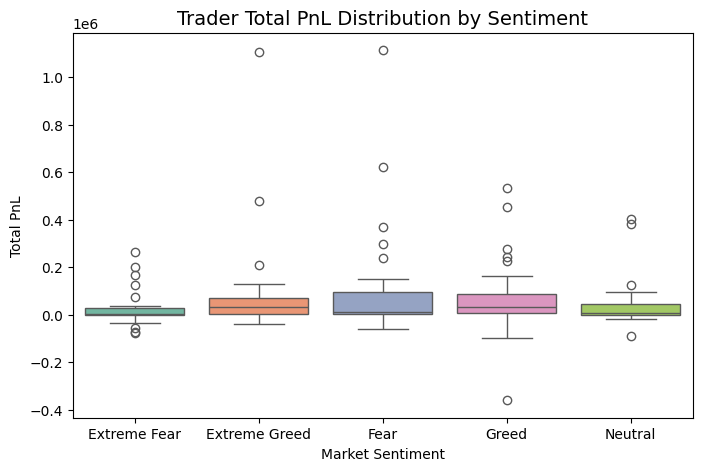

In [10]:
# Step 4: Visualizations

import matplotlib.pyplot as plt
import seaborn as sns

# 1. Distribution of total PnL under Fear vs Greed
plt.figure(figsize=(8,5))
sns.boxplot(x='classification', y='totalPnL', data=metrics, palette="Set2")
plt.title("Trader Total PnL Distribution by Sentiment", fontsize=14)
plt.xlabel("Market Sentiment")
plt.ylabel("Total PnL")
plt.show()

/tmp/ipython-input-3882424373.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top10 = metrics.groupby('classification').apply(lambda x: x.nlargest(10, 'totalPnL')).reset_index(drop=True)


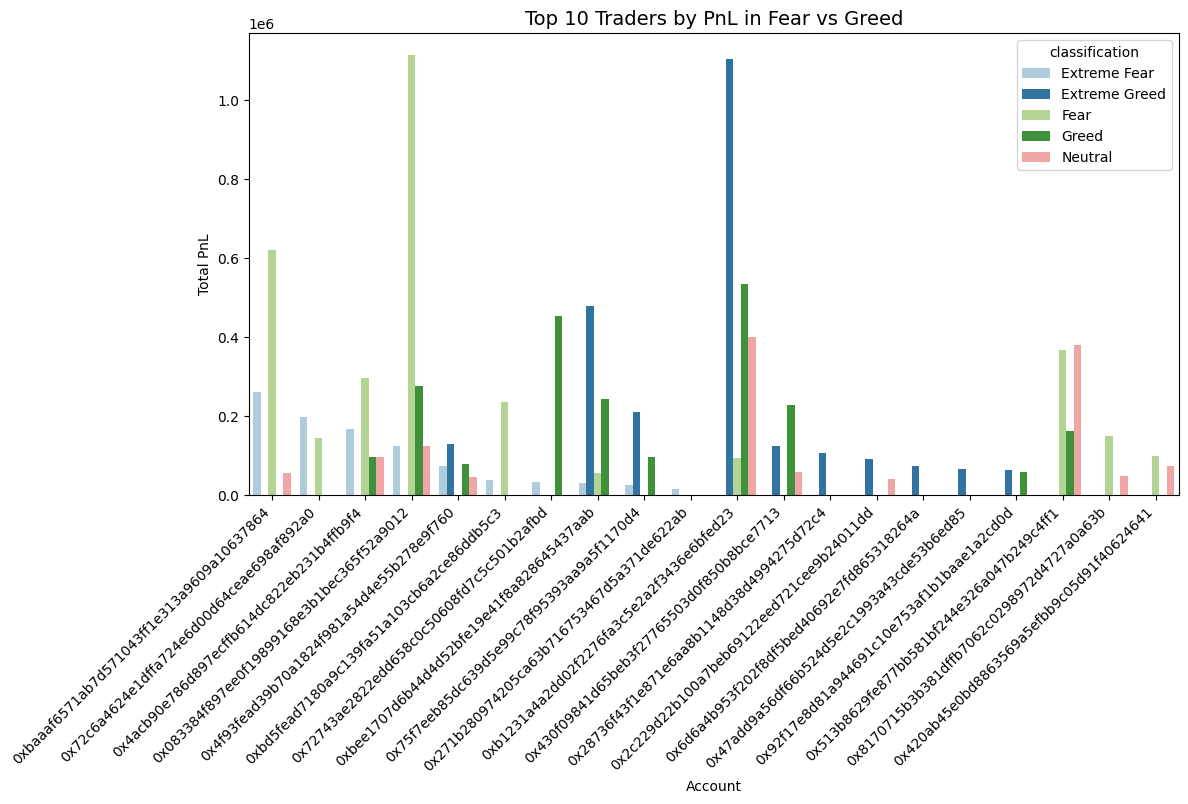

In [12]:
# 2. Top 10 traders in each sentiment regime
top10 = metrics.groupby('classification').apply(lambda x: x.nlargest(10, 'totalPnL')).reset_index(drop=True)

plt.figure(figsize=(12,6))
sns.barplot(x='Account', y='totalPnL', hue='classification', data=top10, dodge=True, palette="Paired")
plt.title("Top 10 Traders by PnL in Fear vs Greed", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.ylabel("Total PnL")
plt.show()

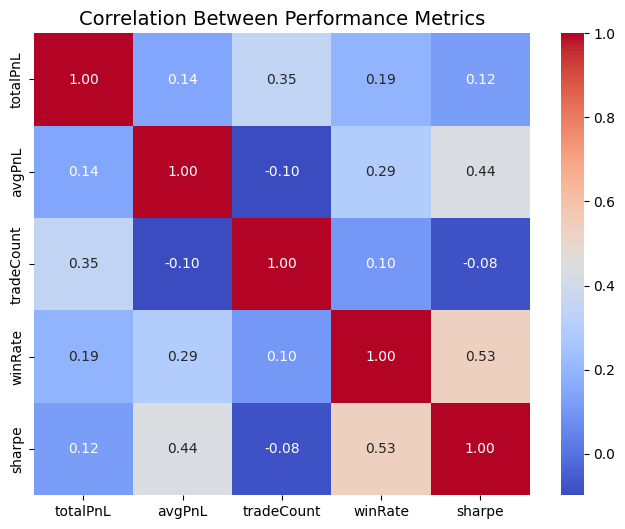

In [13]:
# 3. Correlation heatmap between metrics
corr = metrics[['totalPnL','avgPnL','tradeCount','winRate','sharpe']].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Between Performance Metrics", fontsize=14)
plt.show()